In this notebook, an exploratory analysis of shadowgram processing algorithms will be tried out to see what is the best approach.

First, pick a capture image from a Foucault test on a concave telescope mirror and show it.

In [1]:
import cv2

# Load our input image
#capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_0.0.png')
capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_1.0.png')

# convert color image into grayscale image
capture_gray = cv2.cvtColor(capture, cv2.COLOR_RGB2GRAY)

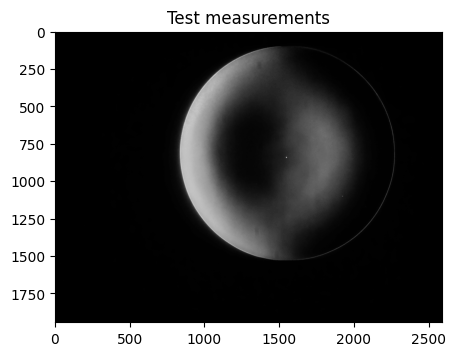

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5, 5]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_gray, cmap='gray')
  
# display that image
plt.show()

Find the center of the shadowgram image of the mirror.

TBD

In [3]:
capture_gray_blur = cv2.blur(capture_gray, (2,2))

threshold = 10

ret, capture_thresh = cv2.threshold(capture_gray_blur, 10, 255, cv2.THRESH_BINARY)

threshold = 80

capture_canny = cv2.Canny(capture_gray_blur, threshold, threshold*2, L2gradient=True)

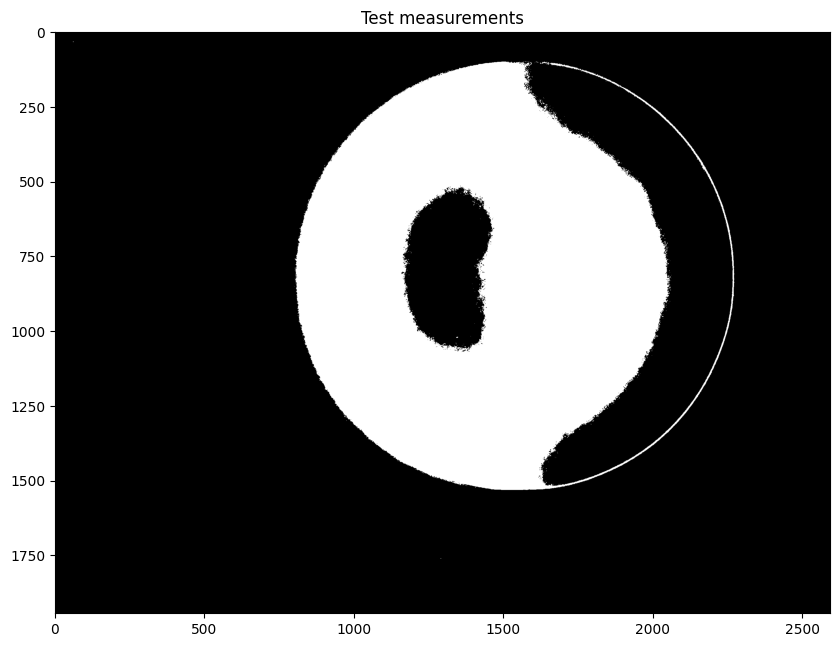

In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_thresh, cmap='gray')
  
# display that image
plt.show()

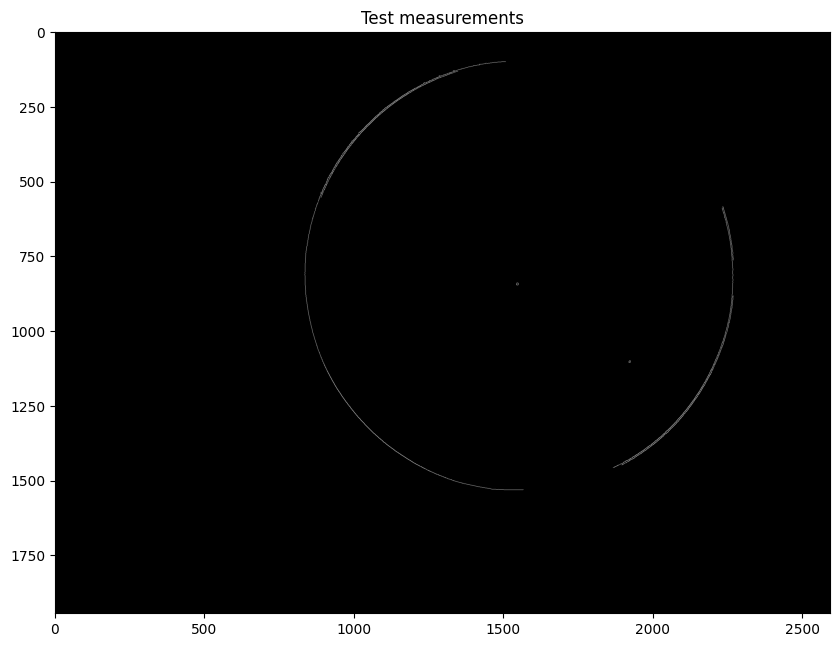

In [5]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_canny, cmap='gray')
  
# display that image
plt.show()

In [6]:
circles = cv2.HoughCircles(capture_gray_blur, cv2.HOUGH_GRADIENT,
                           1, 500, param1=160, param2=30, minRadius=400, maxRadius=1000)

print(circles)

color = (255, 0, 0)
center = (int(circles[0][0][0]), int(circles[0][0][1]))
radius = int(circles[0][0][2])
capture_circles = cv2.circle(capture, center, radius, color, 1)
capture_circles_center = cv2.circle(capture, center, 2, color, 4)

[[[1551.5  818.5  715.9]]]


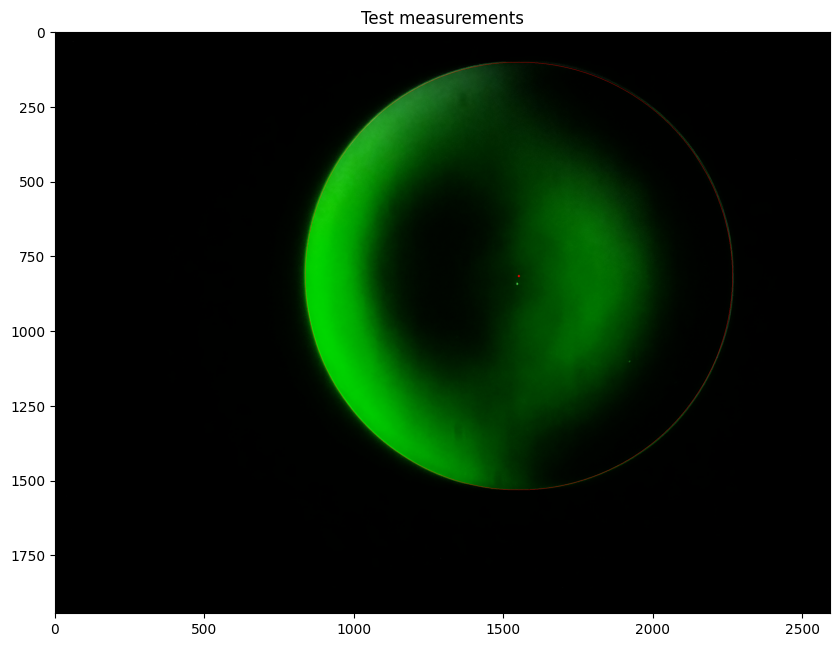

In [7]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_circles, cmap='gray')
#plt.imshow(capture_circles_center, cmap='gray')
  
# display that image
plt.show()

In [8]:
#a = cv2.boundingRect(canny_output)

print(a)

color = (128, 0, 0)
drawing2 = cv2.rectangle(capture_gray, (a[0], a[1]), (a[2], a[3]), color, 2)

NameError: name 'a' is not defined

In [ ]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(drawing2, cmap='gray')
  
# display that image
plt.show()

In [ ]:
import numpy as np

threshold = 100

capture_gray_blur = cv2.blur(capture_gray, (3,3))

canny_output = cv2.Canny(capture_gray_blur, threshold, threshold * 2, L2gradient = True)

contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
centers = [None]*len(contours)
radius = [None]*len(contours)
for i, c in enumerate(contours):
    contours_poly[i] = cv2.approxPolyDP(c, 3, True)
    boundRect[i] = cv2.boundingRect(contours_poly[i])
    centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])
    
drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

for i in range(len(contours)):
    color = (255, 0, 0)
    cv2.drawContours(drawing, contours_poly, i, color)
    cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
                 (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)

In [ ]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(drawing, cmap='gray')
  
# display that image
plt.show()

Flip the resulting image horizontally.

In [ ]:
capture_gray_flip = cv2.flip(capture_gray, 1)

In [ ]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_gray_flip, cmap='gray')
  
# display that image
plt.show()

Subtract both original and flipped images.

In [ ]:
capture_gray_subtract = cv2.subtract(capture_gray, capture_gray_flip)

In [ ]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_gray_subtract, cmap='gray')
  
# display that image
plt.show()

Determine shadowgram radius.